In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
import os
from importlib import reload
import joblib

import nigiwai_random
reload(nigiwai_random)

<module 'nigiwai_random' from '/Users/kaji/Dropbox/maple/COI/Nigiwai_vectorfields/Nigiwai_Randomness/kaji/nigiwai_random.py'>

In [4]:
frame_skip = 2

datadir = "../data/500fr_ratio_twoway"
#datadir = "../data/300fr_spawn"
#datadir = "../data/500fr_speed"

# shopping ratio test data
names = sorted(os.listdir(datadir))
df_list = [nigiwai_random.load_vadere(os.path.join(datadir,fn)) for fn in names]
names = [os.path.splitext(fn)[0] for fn in names]

#coords = [nigiwai_random.vadere_coords(df, frame_skip=frame_skip) for df in tqdm(df_list)]
coords = joblib.Parallel(n_jobs=-1)(joblib.delayed(nigiwai_random.vadere_coords)(df, frame_skip=frame_skip) for df in df_list)



In [5]:
# parameters for indicators
fr_number = 10 # time window for computing Nigiwai
weight_r1_each = 0 # weight of R_1 in Nigiwai for individual pedestrians
weight_r1_all = 1 # weight of R_1 in Nigiwai for all pedestrians
weight_all = 0.5 # weight of Nigiwai for all pedestrians
weight_entropy = 0.5 # weight of entropy
noise_std = 0 # std of gaussian noise for the coordinate

In [6]:
def compute_indicators(df_vadere, weight_r1_each, weight_r1_all, weight_all, weight_entropy, fr_number=9, sampling_ratio=1):
    X, Y = nigiwai_random.add_noise_to_coords(df_vadere[0],df_vadere[1],noise_std)
    u, v = nigiwai_random.compute_velocity(X,Y,noise_std)
    
    L_all = []
    # iterate over frames
    for target_fr in range(fr_number, X.shape[1]-1):
        L = dict()
        u_f = u[:,target_fr-fr_number:target_fr+1]
        v_f = v[:,target_fr-fr_number:target_fr+1]

        ped_mask = ~np.isnan( (u_f.sum(axis=1)+v_f.sum(axis=1)) )
        sampling = np.random.choice(np.where(ped_mask==True)[0],replace=False,size=int((1-sampling_ratio)*(ped_mask).sum()))
        ped_mask[sampling] = False
        #print(ped_mask.sum(),np.where(ped_mask==True)[0],sampling,"\n")
        u_f = u_f[ped_mask]
        v_f = v_f[ped_mask]

        all_mask = ~np.isnan( u[:,target_fr]+v[:,target_fr] )
        sampling = np.random.choice(np.where(all_mask==True)[0],replace=False,size=int((1-sampling_ratio)*(all_mask).sum()))
        all_mask[sampling] = False
        u_g = u[all_mask,target_fr].reshape(1,-1)
        v_g = v[all_mask,target_fr].reshape(1,-1)        
        
        # indicators
        if len(u_f)>0:
            L['r1_each'] = nigiwai_random.compute_moment(u_f,v_f,1)
            L['r2_each'] = nigiwai_random.compute_moment(u_f,v_f,2)
            L['nig_each'] = np.maximum(1 - (weight_r1_each*L['r1_each'] + (1-weight_r1_each)*L['r2_each']),0)
            L['nig_ent'] =  nigiwai_random.entropy_base(u_f,v_f)
            L['nig_each_weighted'] = (L['nig_ent'] ** weight_entropy) * (L['nig_each'] ** (1-weight_entropy))
            L['nig_each_weighted_mean'] = L['nig_each_weighted'].mean()
            L['nig_each_mean'] = L['nig_each'].mean()
        else:
            L['nig_each_mean'] = np.zeros(1)
            L['nig_each_weighted_mean'] = np.zeros(1)
            L['nig_ent'] = np.zeros(1)

        if len(u_g)>0:
            L['r1_all'] = nigiwai_random.compute_moment(u_g,v_g,1)
            L['r2_all'] = nigiwai_random.compute_moment(u_g,v_g,2)
            L['nig_all'] = np.maximum(1 - (weight_r1_all*L['r1_all']   + (1-weight_r1_all)*L['r2_all']),0)
        else:
            L['nig_all'] = np.zeros(1)

        # aggregated indicators
        L['Nig'] = (L['nig_all']**weight_all) * ( L['nig_each_weighted_mean'] **(1-weight_all))
        
        L_all.append(L)

    L_res = dict()
    for k in ['nig_each_mean','nig_all','nig_ent','Nig']:
        L_res[k] = nigiwai_random.moving_average([L[k].mean() for L in L_all], alpha=0.8, window=15, method='rolling')
    return(L_res)



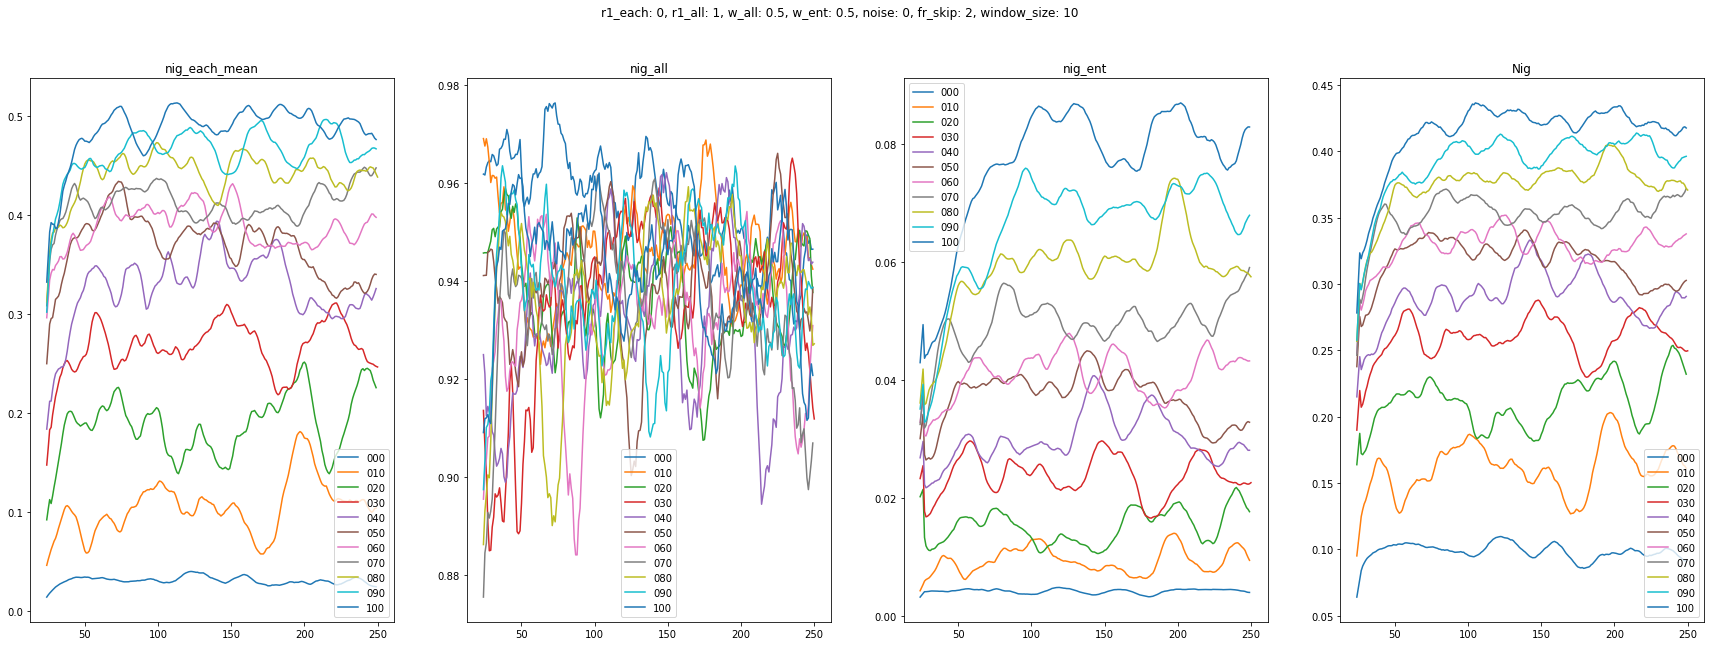

In [8]:

sampling_ratio = 1.0

# plot graphs
fig,ax = plt.subplots(1,4,figsize=(30, 10))
fig.suptitle(f'r1_each: {weight_r1_each}, r1_all: {weight_r1_all}, w_all: {weight_all}, w_ent: {weight_entropy}, noise: {noise_std}, fr_skip: {frame_skip}, window_size: {fr_number}')
st = 10
for i,df_vadere in enumerate(coords):
    L_res = compute_indicators(df_vadere, weight_r1_each, weight_r1_all, weight_all, weight_entropy, fr_number=9, sampling_ratio=sampling_ratio)
    for j,k in enumerate(L_res.keys()):
        ax[j].plot(np.arange(len(L_res[k][st:]))+fr_number+st, L_res[k][st:], label=names[i])
        ax[j].set_title(k)
        ax[j].legend()
plt.show()